In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.affinity import scale, translate
import gzbuilder_analysis.parsing as pg
import gzbuilder_analysis.aggregation as ag
import lib.galaxy_utilities as gu
from asinh_cmap import asinh_cmap, asinh_cmap_r
import lib.make_cutouts as mkct

In [3]:
subject_ids = [20902011, 20902022, 20902026, 20902027, 20902040]

In [4]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')

In [5]:
zoo_models = {}
scaled_models = {}
for s in subject_ids:
    data = fitting_metadata.loc[s].galaxy_data
    psf = fitting_metadata.loc[s].psf
    sigma_image = fitting_metadata.loc[s].sigma_image
    pic_array = np.array(gu.get_image(s))
    cls_for_subjects = gu.classifications.query(
        f'subject_ids == {s}'
    )
    zoo_models[s] = cls_for_subjects.apply(
        pg.parse_classification,
        axis=1,
        image_size=np.array(pic_array.shape),
        size_diff=fitting_metadata['size_diff'],
        ignore_scale=True  # ignore scale slider when aggregating
    )
    scaled_models[s] = zoo_models[s].apply(
        pg.scale_model,
        args=(fitting_metadata.loc[s]['size_diff'],),
    )

In [6]:
rot_matrix = lambda t: np.array(((np.cos(t), np.sin(t)), (-np.sin(t), np.cos(t))))

def plot_thing(s, model):
    img = np.array(gu.download_image(s))
    subject_data = json.loads(requests.get(json.loads(gu.subjects.loc[s].locations)['0']).text)
    zoo_mask = np.array(subject_data['mask'])
    zoo_gal = np.ma.masked_array(subject_data['imageData'], zoo_mask)
    montaged_cutout = mkct.get_montaged_cutout(s).data
    montaged_mask = gu.get_diff_data(s)['mask']

    rotated_model = pg.rotate_model_about_centre(model, zoo_gal.data.shape, fitting_metadata.loc[s].rotation_correction)
    reprojected_model = pg.reproject_model(
        rotated_model,
        fitting_metadata.loc[s]['montage_wcs'],
        fitting_metadata.loc[s]['original_wcs'],
    )

    f, ax = plt.subplots(ncols=3, figsize=(12, 4), dpi=100)
    ax[0].imshow(zoo_gal, cmap=asinh_cmap)
    for i, (k, g) in enumerate(
        ag.get_geoms(model).items()
    ):
        if g is not None:
            ax[0].add_patch(PolygonPatch(scale(g, 3, 3), fc='none', ec=f'C{i}'))
    for points, params in model['spiral']:
        ax[0].plot(*points.T, 'r')
    ax[0].set_title('Zooniverse data')
    l = montaged_cutout[
        int(montaged_cutout.shape[0]/2) - 20: int(montaged_cutout.shape[0]/2) + 20,
        int(montaged_cutout.shape[1]/2) - 20: int(montaged_cutout.shape[1]/2) + 20,
    ].max()
    ax[1].imshow(np.ma.masked_array(montaged_cutout, montaged_mask), vmax=l, cmap=asinh_cmap)
    for i, (k, g) in enumerate(
        ag.get_geoms(rotated_model).items()
    ):
        if g is not None:
            ax[1].add_patch(PolygonPatch(scale(g, 3, 3), fc='none', ec=f'C{i}'))
    for points, params in rotated_model['spiral']:
        ax[1].plot(*points.T, 'r')
    ax[1].set_title('Montaged cutout')
    ax[2].imshow(fitting_metadata.loc[s].galaxy_data, cmap=asinh_cmap)
    for i, (k, g) in enumerate(
        ag.get_geoms(reprojected_model).items()
    ):
        if g is not None:
            ax[2].add_patch(PolygonPatch(scale(g, 3, 3), fc='none', ec=f'C{i}'))
    for points, params in reprojected_model['spiral']:
        ax[2].plot(*points.T, 'r')
    ax[2].set_title('Fitting data')
    return f, ax

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
W0131 16:39:52.369778 4481686976 logger.py:200] FITSFixedWarning: RADECSYS= 'ICRS ' / International Celestial Ref. System 
the RADECSYS keyword is deprecated, use RADESYSa.


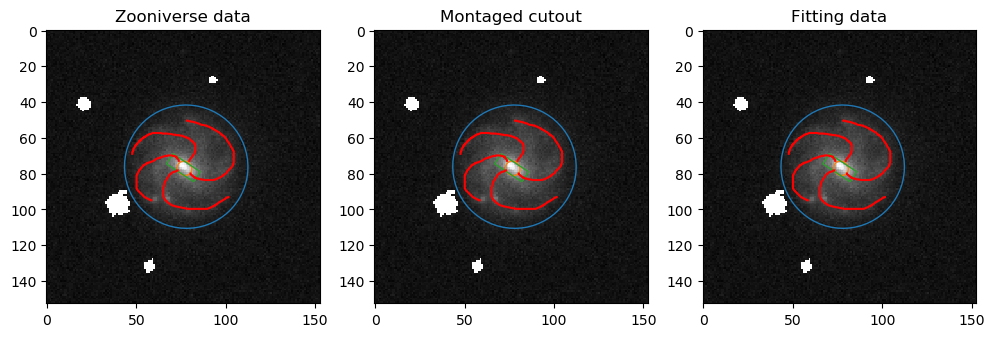

In [7]:
f, ax = plot_thing(subject_ids[0], scaled_models[subject_ids[0]].iloc[4])

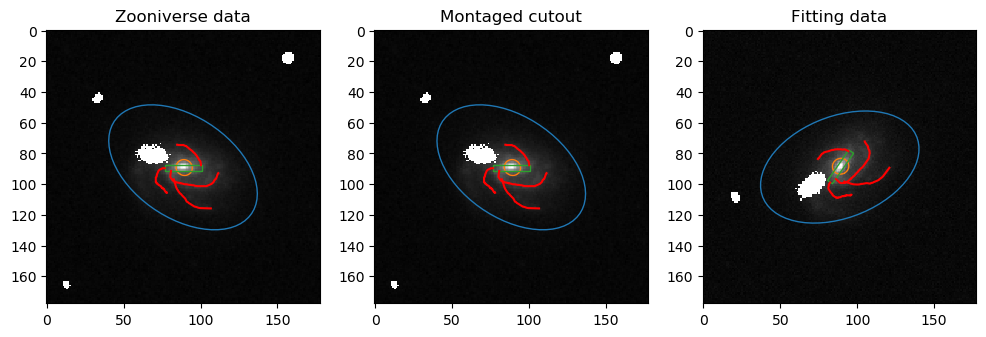

In [8]:
f, ax = plot_thing(subject_ids[1], scaled_models[subject_ids[1]].iloc[3])

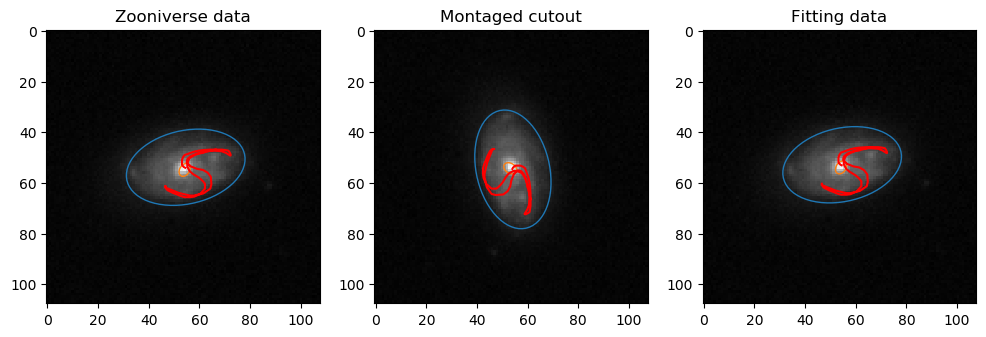

In [9]:
f, ax = plot_thing(subject_ids[2], scaled_models[subject_ids[2]].iloc[14])

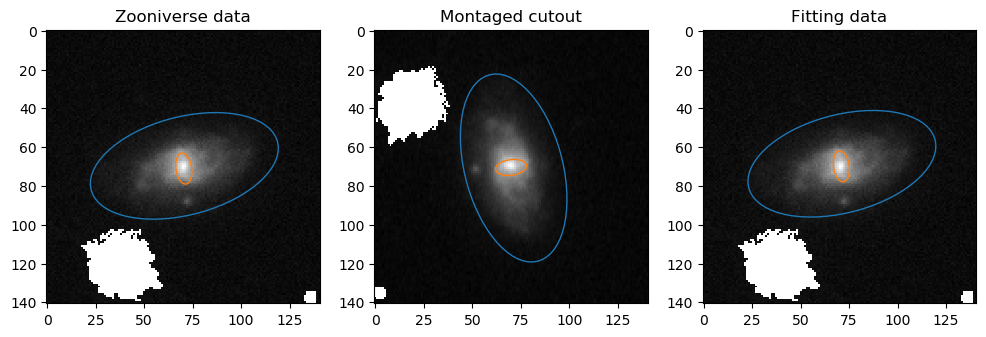

In [10]:
f, ax = plot_thing(subject_ids[3], scaled_models[subject_ids[3]].iloc[18])

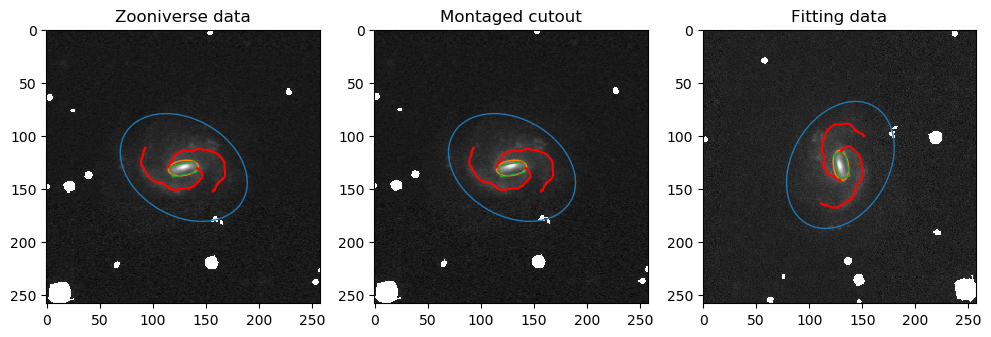

In [11]:
f, ax = plot_thing(subject_ids[4], scaled_models[subject_ids[4]].iloc[11])